In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [4]:
df = pd.read_csv('Basic_Stats.csv')
print(df.shape)
df['Tournament App?'] = df['School'].str.contains('NCAA', case=True)*1 # 1 if tournament appearance
df.head()

(9802, 33)


,School,Games Played,Wins,Losses,W-L%,Simple Rating System,Strength of Schedule,Conf. Wins,Conf. Losses,Home Wins,...,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Year,Tournament App?
0,Air Force,28,5,23,0.179,-5.62,5.05,1.0,17.0,5.0,...,0.628,NaN,1040.0,385.0,154.0,79.0,403.0,555.0,1996,0
1,Akron,26,3,23,0.115,-11.16,2.52,0.0,18.0,2.0,...,0.695,NaN,782.0,307.0,147.0,60.0,372.0,454.0,1996,0
2,Alabama,32,19,13,0.594,6.99,6.11,9.0,7.0,12.0,...,0.663,NaN,1252.0,408.0,197.0,196.0,440.0,567.0,1996,0
3,Alabama State,27,9,18,0.333,-23.42,-12.79,5.0,9.0,5.0,...,0.644,NaN,834.0,289.0,225.0,51.0,326.0,482.0,1996,0
4,Alcorn State,25,10,15,0.400,-18.20,-9.20,7.0,7.0,7.0,...,0.658,NaN,1009.0,354.0,233.0,90.0,472.0,558.0,1996,0


In [6]:
# Introduce per game stats
for per_game_col in df.columns[13:32]:
    if '%' in per_game_col:
        continue
    else:
        df[per_game_col+' Per Game'] = df[per_game_col]/df['Games Played']
df.head()

,School,Games Played,Wins,Losses,W-L%,Simple Rating System,Strength of Schedule,Conf. Wins,Conf. Losses,Home Wins,...,3PA Per Game,FTM Per Game,FTA Per Game,ORB Per Game,TRB Per Game,AST Per Game,STL Per Game,BLK Per Game,TOV Per Game,PF Per Game
305,Air Force,26,7,19,0.269,-4.91,1.18,2.0,14.0,6.0,...,16.769231,13.769231,22.115385,14.769231,38.653846,13.461538,5.961538,1.538462,15.615385,20.538462
306,Akron,26,8,18,0.308,-1.18,0.98,6.0,12.0,6.0,...,15.461538,13.769231,19.769231,11.038462,33.423077,15.653846,8.461538,3.000000,13.653846,18.384615
309,Alcorn State,28,11,17,0.393,-15.53,-10.16,8.0,6.0,7.0,...,12.928571,17.142857,26.642857,13.750000,40.500000,14.964286,6.857143,3.821429,18.857143,21.035714
313,Arizona State,30,10,20,0.333,2.24,7.21,2.0,16.0,9.0,...,18.733333,11.100000,16.700000,13.033333,34.700000,17.766667,9.966667,5.733333,14.366667,18.300000
315,Arkansas State,27,15,12,0.556,-5.48,-4.48,8.0,10.0,11.0,...,14.851852,15.407407,23.222222,12.740741,35.629630,14.666667,7.148148,4.111111,15.185185,18.851852


In [7]:
# Let's focus the analysis to 2019-2010 to not have to bother with NaN entries for now
df = df[(df['Year'] >= 2010) & (df['Year'] <= 2019)]
df.columns

Index(['School', 'Games Played', 'Wins', 'Losses', 'W-L%',
       'Simple Rating System', 'Strength of Schedule', 'Conf. Wins',
       'Conf. Losses', 'Home Wins', 'Home Losses', 'Away Wins', 'Away Losses',
       'Total Pts Scored', 'Total Pts Suffered', 'Minutes Played', 'FGM',
       'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'Year', 'Tournament App?',
       'Total Pts Scored Per Game', 'Total Pts Suffered Per Game',
       'Minutes Played Per Game', 'FGM Per Game', 'FGA Per Game',
       '3PM Per Game', '3PA Per Game', 'FTM Per Game', 'FTA Per Game',
       'ORB Per Game', 'TRB Per Game', 'AST Per Game', 'STL Per Game',
       'BLK Per Game', 'TOV Per Game', 'PF Per Game'],
      dtype='object')

### Logistic Regression with 5-Fold CV on Number of Features to Select for RFE

Best number of features: 10
Selected features: Index(['FGM Per Game', 'FGA Per Game', '3PM Per Game', 'FTM Per Game',
       'ORB Per Game', 'TRB Per Game', 'STL Per Game', 'BLK Per Game',
       'TOV Per Game', 'PF Per Game'],
      dtype='object')
Test Accuracy with 10 features: 0.8543


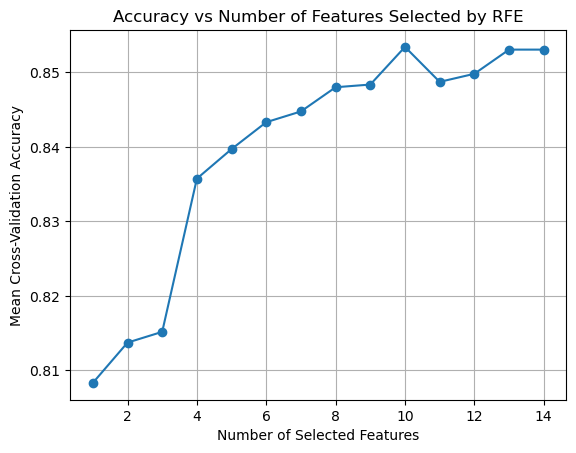

In [14]:
df = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df[['Minutes Played Per Game', 'FGM Per Game', 'FGA Per Game',
       '3PM Per Game', '3PA Per Game', 'FTM Per Game', 'FTA Per Game',
       'ORB Per Game', 'TRB Per Game', 'AST Per Game', 'STL Per Game',
       'BLK Per Game', 'TOV Per Game', 'PF Per Game']], df['Tournament App?'], 
       test_size=0.2, random_state=40)

model = LogisticRegression(max_iter=1000)
rfe = RFE(model)

param_grid = {'n_features_to_select': list(range(1, X_train.shape[1] + 1))}

grid_search = GridSearchCV(rfe, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

best_n_features = grid_search.best_params_['n_features_to_select']
best_model = grid_search.best_estimator_

selected_features = X_train.columns[best_model.support_]
print(f"Best number of features: {best_n_features}")
print("Selected features:", selected_features)

test_score = best_model.score(X_test, y_test)
print(f"Test Accuracy with {best_n_features} features: {test_score:.4f}")

mean_cv_scores_rfe = grid_search.cv_results_['mean_test_score']

plt.plot(range(1, X_train.shape[1] + 1), mean_cv_scores_rfe, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Accuracy vs. Number of Features Selected by RFE')
plt.grid(True)
plt.show()

### Lasso with 5-Fold CV on Regularization Parameter $\alpha$

Best alpha: 0.01
Selected features: Index(['Minutes Played Per Game', 'FGM Per Game', 'FGA Per Game',
       '3PM Per Game', 'FTM Per Game', 'ORB Per Game', 'TRB Per Game',
       'AST Per Game', 'STL Per Game', 'BLK Per Game', 'TOV Per Game',
       'PF Per Game'],
      dtype='object')
Test Mean Squared Error with Lasso: 0.1091


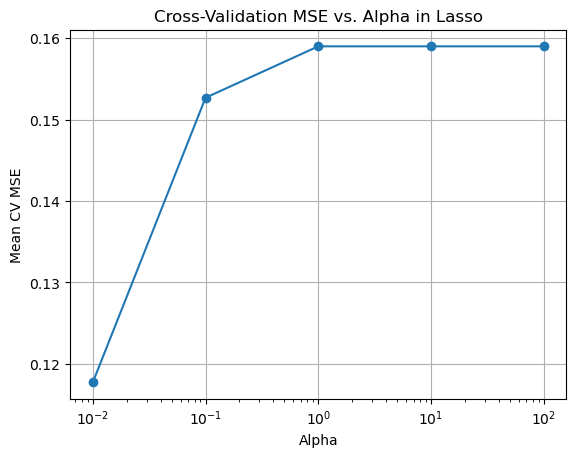

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(max_iter=1000)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_alpha = grid_search.best_params_['alpha']
best_lasso = grid_search.best_estimator_

print(f"Best alpha: {best_alpha}")
selected_features = X_train.columns[np.where(best_lasso.coef_ != 0)]
print("Selected features:", selected_features)

y_pred_test = best_lasso.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Test Mean Squared Error with Lasso: {test_mse:.4f}")

mean_cv_scores_lasso = -grid_search.cv_results_['mean_test_score']  # Convert to positive MSE

# Plot the results
plt.plot(param_grid['alpha'], mean_cv_scores_lasso, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean CV MSE')
plt.title('Cross-Validation MSE vs. Alpha in Lasso')
plt.xscale('log')
plt.grid(True)
plt.show()

### Decision Tree 5-Fold CV on Max Depth and Min Samples Split

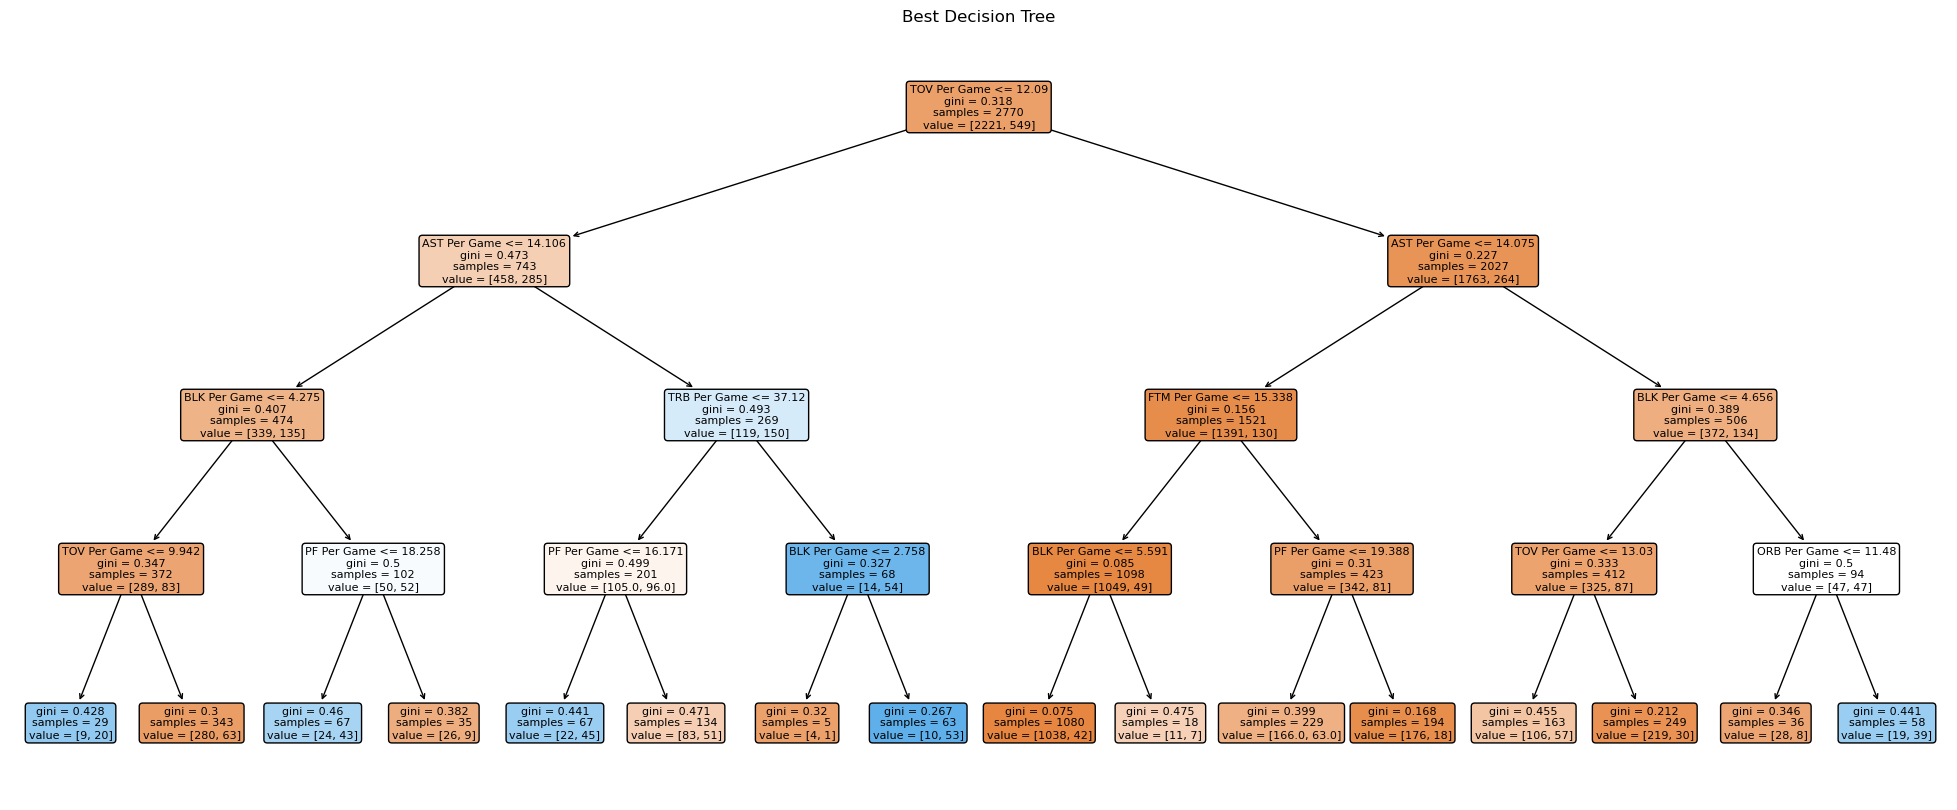

Best Decision Tree model: DecisionTreeClassifier(max_depth=4)
Decision Tree Test Accuracy: 0.8283


In [8]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {'max_depth': [3, 4, 5], 'min_samples_split': [2, 10, 20]}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Best Decision Tree model
best_dt = grid_search_dt.best_estimator_

plt.figure(figsize=(25, 10))
plot_tree(best_dt, filled=True, feature_names=X_train.columns, rounded=True, fontsize=8)
plt.title("Best Decision Tree")
plt.show()

dt_accuracy = best_dt.score(X_test, y_test)
print(f"Best Decision Tree model: {best_dt}")
print(f"Decision Tree Test Accuracy: {dt_accuracy:.4f}")

### Random Forest with 5-Fold CV on Number of Estimators, Max Depth, and Min Samples Split

In [9]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 10, 20]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Best Random Forest model and score
best_rf = grid_search_rf.best_estimator_
print(f"Best Random Forest model: {best_rf}")
print(f"Best score (accuracy): {grid_search_rf.best_score_:.4f}")

# Feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = indices[:3]

print("Top features:", X_train.columns[top_features])

Best Random Forest model: RandomForestClassifier(max_depth=5)
Best score (accuracy): 0.8267
Top features: Index(['TOV Per Game', 'AST Per Game', 'FGM Per Game'], dtype='object')
